<a href="https://colab.research.google.com/github/anopsy/MyFalaClassifier/blob/main/transfer_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



I mount my google drive, where I store data



In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import os
import tensorflow as tf

base_dir = '/content/gdrive/MyDrive/waves'

print("Contents of base directory:")
print(os.listdir(base_dir))

print("\nContents of train directory:")
print(os.listdir(f'{base_dir}/train'))

print("\nContents of validation directory:")
print(os.listdir(f'{base_dir}/validation'))

Contents of base directory:
['train', 'validation']

Contents of train directory:
['good_waves', 'bad_waves']

Contents of validation directory:
['good_waves', 'bad_waves']


Creating directories for later use

In [5]:
import os

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with training good_waves/bad_waves pictures
train_gw_dir = os.path.join(train_dir, 'good_waves')
train_bw_dir = os.path.join(train_dir, 'bad_waves')

# Directory with validation good_waves/bad_waves pictures
validation_gw_dir = os.path.join(validation_dir, 'good_waves')
validation_bw_dir = os.path.join(validation_dir, 'bad_waves')

Checking on file names and number of images

In [6]:
train_gw_fnames = os.listdir( train_gw_dir )
train_bw_fnames = os.listdir( train_bw_dir )

print(train_gw_fnames[:10])
print(train_bw_fnames[:10])

['goodwave579.jpg', 'goodwave586.jpg', 'goodwave581.jpg', 'goodwave582.jpg', 'goodwave583.jpg', 'goodwave584.jpg', 'goodwave585.jpg', 'goodwave592.jpg', 'goodwave588.jpg', 'goodwave587.jpg']
['badwave607.jpg', 'badwave613.jpg', 'badwave610.jpg', 'badwave612.jpg', 'badwave609.jpg', 'badwave611.jpg', 'badwave618.jpg', 'badwave616.jpg', 'badwave614.jpg', 'badwave615.jpg']


In [7]:
print('total training good waves images :', len(os.listdir(      train_gw_dir ) ))
print('total training bad waves images :', len(os.listdir(      train_bw_dir ) ))

print('total validation good waves images :', len(os.listdir( validation_gw_dir ) ))
print('total validation bad waves images :', len(os.listdir( validation_bw_dir ) ))

total training good waves images : 701
total training bad waves images : 702
total validation good waves images : 349
total validation bad waves images : 349


Plotting examples of images in each directory

In [8]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

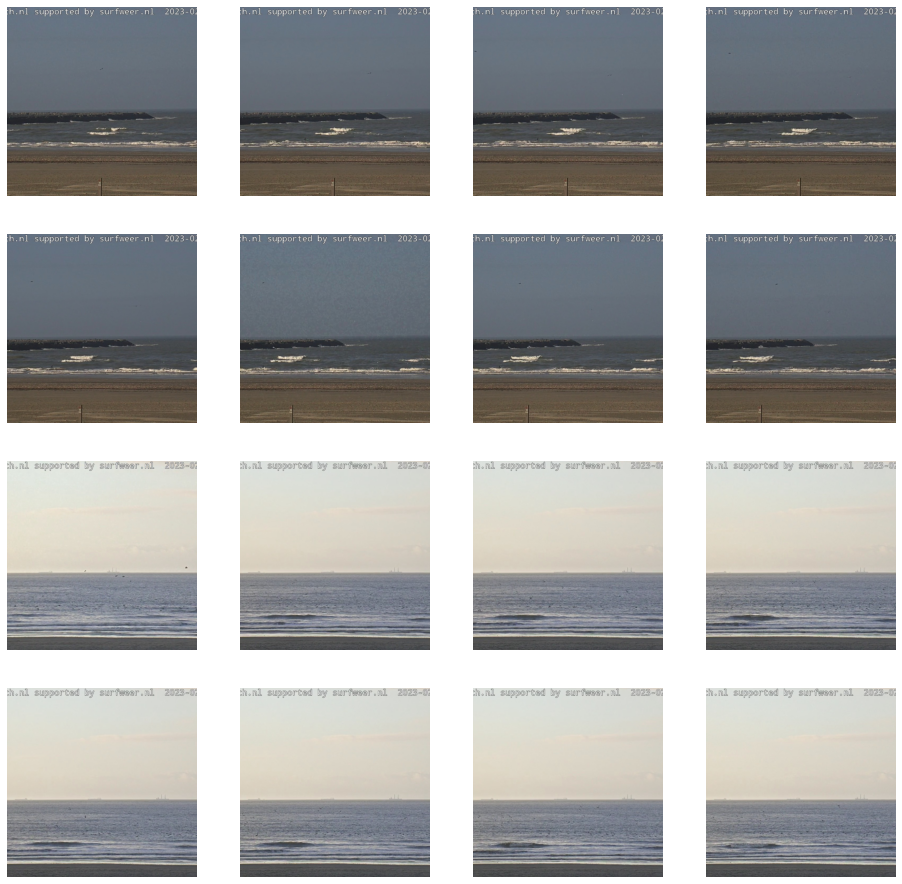

In [9]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_gw_pix = [os.path.join(train_gw_dir, fname) 
                for fname in train_gw_fnames[ pic_index-8:pic_index] 
               ]

next_bw_pix = [os.path.join(train_bw_dir, fname) 
                for fname in train_bw_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_gw_pix+next_bw_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


In [10]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [11]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 1403 files belonging to 2 classes.


In [12]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 698 files belonging to 2 classes.


Simple baseline model

In [13]:

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [14]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [15]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [16]:
base_model.trainable = False

In [17]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [19]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [20]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [21]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [23]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

22/22 [==============================] - 101s 3s/step - loss: 0.7716 - accuracy: 0.4871


In [24]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.77
initial accuracy: 0.49


In [25]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
44/44 [==============================] - 58s 1s/step - loss: 0.8055 - accuracy: 0.4412 - val_loss: 0.6854 - val_accuracy: 0.6060
Epoch 2/10
44/44 [==============================] - 59s 1s/step - loss: 0.7223 - accuracy: 0.5175 - val_loss: 0.6245 - val_accuracy: 0.6719
Epoch 3/10
44/44 [==============================] - 53s 1s/step - loss: 0.6582 - accuracy: 0.5731 - val_loss: 0.5733 - val_accuracy: 0.7450
Epoch 4/10
44/44 [==============================] - 53s 1s/step - loss: 0.6197 - accuracy: 0.6023 - val_loss: 0.5295 - val_accuracy: 0.7908
Epoch 5/10
44/44 [==============================] - 52s 1s/step - loss: 0.5799 - accuracy: 0.6600 - val_loss: 0.4955 - val_accuracy: 0.8166
Epoch 6/10
44/44 [==============================] - 53s 1s/step - loss: 0.5450 - accuracy: 0.7014 - val_loss: 0.4661 - val_accuracy: 0.8438
Epoch 7/10
44/44 [==============================] - 53s 1s/step - loss: 0.5158 - accuracy: 0.7341 - val_loss: 0.4421 - val_accuracy: 0.8754
Epoch 8/10
44/44 [==

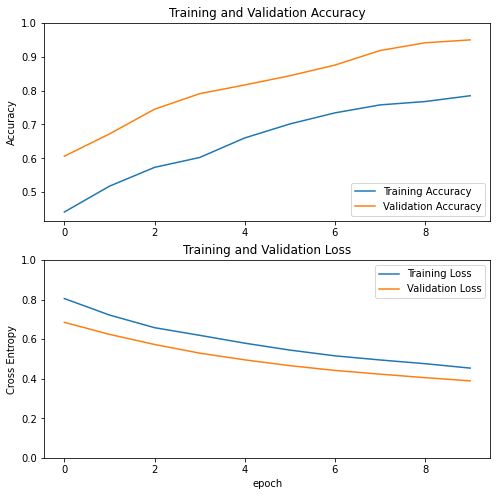

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [27]:
base_model.trainable = True

In [28]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [29]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [31]:
len(model.trainable_variables)

56

In [32]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
44/44 [==============================] - 82s 2s/step - loss: 0.3145 - accuracy: 0.8667 - val_loss: 0.2587 - val_accuracy: 0.9456
Epoch 11/20
44/44 [==============================] - 75s 2s/step - loss: 0.1998 - accuracy: 0.9152 - val_loss: 0.5386 - val_accuracy: 0.7966
Epoch 12/20
44/44 [==============================] - 75s 2s/step - loss: 0.1640 - accuracy: 0.9309 - val_loss: 0.2946 - val_accuracy: 0.9054
Epoch 13/20
44/44 [==============================] - 74s 2s/step - loss: 0.1371 - accuracy: 0.9373 - val_loss: 0.4731 - val_accuracy: 0.8324
Epoch 14/20
44/44 [==============================] - 75s 2s/step - loss: 0.1246 - accuracy: 0.9522 - val_loss: 0.6273 - val_accuracy: 0.7622
Epoch 15/20
44/44 [==============================] - 74s 2s/step - loss: 0.1053 - accuracy: 0.9629 - val_loss: 0.6797 - val_accuracy: 0.7493
Epoch 16/20
44/44 [==============================] - 78s 2s/step - loss: 0.0854 - accuracy: 0.9694 - val_loss: 0.6873 - val_accuracy: 0.7607
Epoch 17/20
4

In [33]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

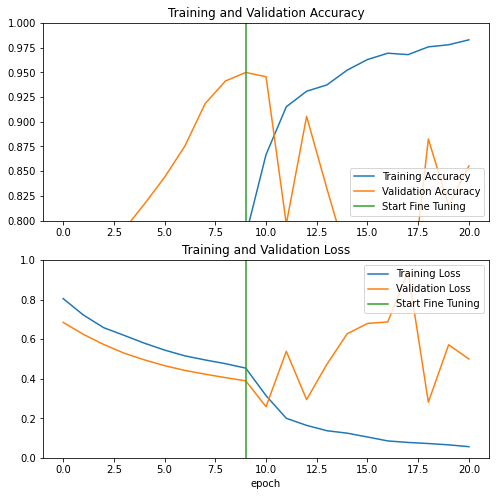

In [34]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [35]:


val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)

In [36]:


print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))



Number of validation batches: 22
Number of test batches: 4


In [37]:


loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

4/4 [==============================] - 6s 646ms/step - loss: 0.4007 - accuracy: 0.8906
Test accuracy : 0.890625


Upload an image and let the model ppredict if it's a good wave or a bad wave

In [38]:


class_names = train_dataset.class_names

Predictions:
 [1 0 1 1 0 0 1 1 0 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 0 1 1 1 1 1 0 1]
Labels:
 [0 0 1 1 0 0 0 1 0 1 1 0 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0 0 1 1 0 1]


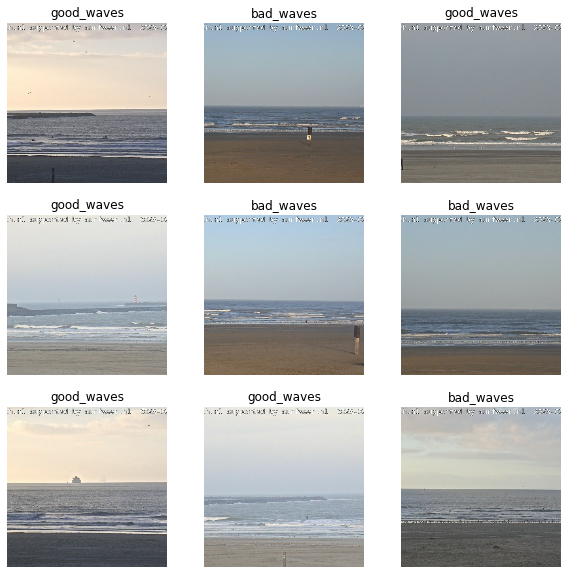

In [39]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

Showing training stats

Clean up

In [ ]:
import os, signal

os.kill(os.getpid(), signal.SIGKILL)